In [21]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr


In [22]:
# test gradio

def shout(text):
    print(f"Shout has been called with input {text}")
    return text.upper()

gr.Interface(fn=shout, inputs="textbox", outputs="textbox", flagging_mode="never").launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://8fe1d66e4be82a9cc2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Shout has been called with input this is a test text


In [23]:
# Initialization

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

In [24]:
# System Prompt: Nutritionist Assistant

system_message = "You are a helpful nutritionist who analyzes foods, dishes, and drinks."
system_message += "For each item, estimate calories, macronutrients (carbs, protein, fats), and key nutrients"
system_message += "No more than few lines of answerUse approximate values, state assumptions when needed, and avoid medical advice."

In [25]:
# Check chat function

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


In [26]:
# Let's start by making a useful function

food_prices = {"coffee": "$3.50", "burger": "$5.00", "salad": "$4.00", "ice cream": "$3.00", "pizza": "$6.00", "sushi": "$8.00", "ramen": "$7.00", "biryani": "$15.00", "smoothie": "$6.00"}

def get_food_price(what_food):
    print(f"Tool get_food_price called for {what_food}")
    food = what_food.lower()
    return food_prices.get(food, "Unknown")

In [27]:
get_food_price("burger")

Tool get_food_price called for burger


'$5.00'

In [28]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_food_price",
    "description": "Get the price of a food item. Call this whenever you need to know the food price, for example when a customer asks 'How much is a burger'",
    "parameters": {
        "type": "object",
        "properties": {
            "what_food": {
                "type": "string",
                "description": "The food item that the customer wants to know the price of",
            },
        },
        "required": ["what_food"],
        "additionalProperties": False
    }
}


In [29]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [30]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    food = arguments.get('what_food')
    price = get_food_price(food)
    response = {
        "role": "tool",
        "content": json.dumps({"what_food": food,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, food

In [31]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, food = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Tool get_food_price called for pizza
Tool get_food_price called for burger


In [33]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [34]:
def artist(food):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"A vibrant, high-detail illustration of a beautifully plated serving of {food}, presented as it would be served in an authentic restaurant. The scene highlights the unique characteristics of {food}—its texture, colors, garnishes, and traditional presentation. The environment is lively and warm, with ambient restaurant lighting, subtle background details, and a sense of cultural authenticity. Cinematic composition, realistic lighting, shallow depth of field, ultra-high resolution.",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

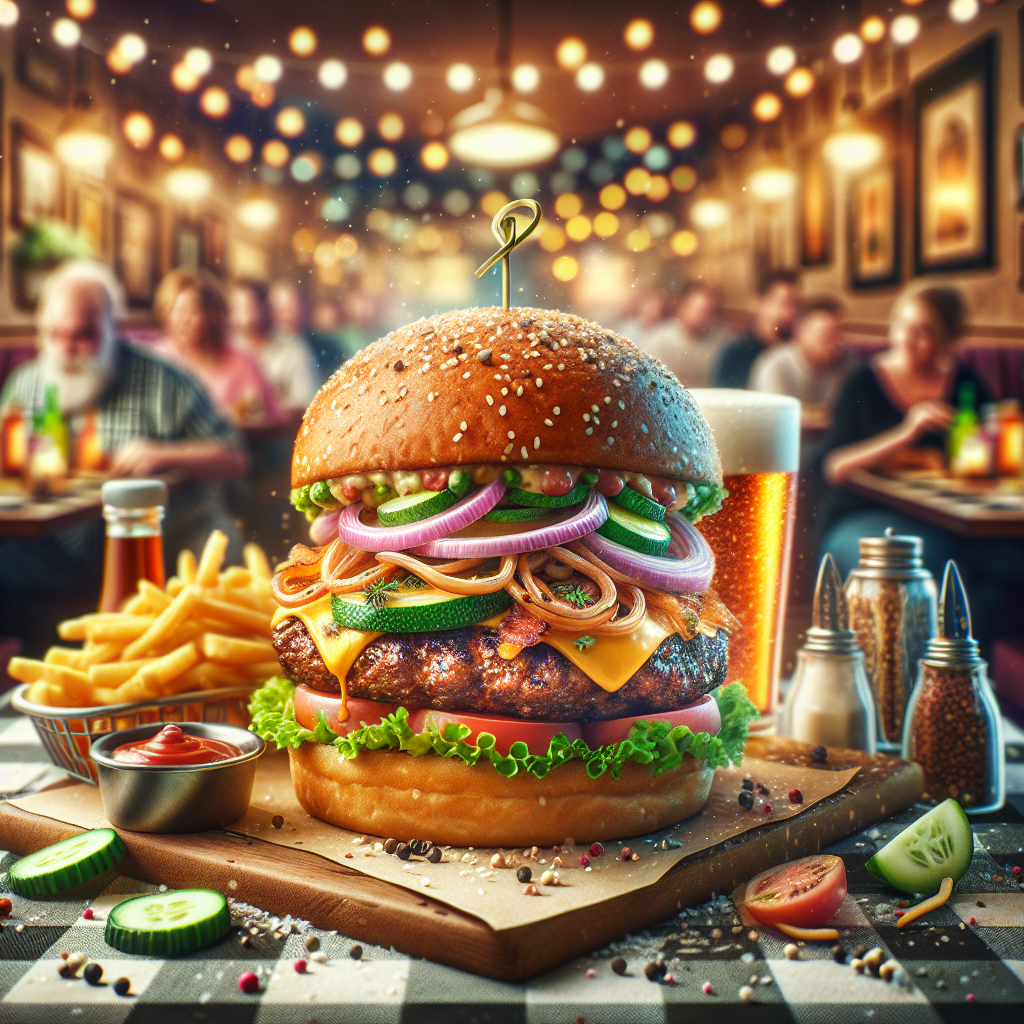

In [35]:
image = artist("burger")
display(image)

In [36]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

ffmpeg version 8.0.1 Copyright (c) 2000-2025 the FFmpeg developers
built with Apple clang version 17.0.0 (clang-1700.4.4.1)
configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enab

In [37]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      #voice="onyx",
      voice="alloy",
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [38]:
talker("Well, hi there. I love biryani")

Input #0, wav, from '/var/folders/5n/nk7xdvpx42d8qxmj8xthhy4h0000gn/T/tmpziwrzx1m.wav':
  Duration: 00:00:01.75, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


In [39]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, food = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(food)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    talker(reply)
    
    return history, image

In [40]:
# More involved Gradio code as we're not using the preset Chat interface!
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


Tool get_food_price called for biryani


Input #0, wav, from '/var/folders/5n/nk7xdvpx42d8qxmj8xthhy4h0000gn/T/tmpgreyf2tk.wav':
  Duration: 00:00:07.90, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_food_price called for biryani


Input #0, wav, from '/var/folders/5n/nk7xdvpx42d8qxmj8xthhy4h0000gn/T/tmp8ws40dtj.wav':
  Duration: 00:00:08.14, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/5n/nk7xdvpx42d8qxmj8xthhy4h0000gn/T/tmpi921k218.wav':
  Duration: 00:00:15.46, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
